# Installing the required dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

Added six different libraries
- Tensorflow
- Tensoflow-gpu
- openCV (Computer Vision library)
- mediapipe (allows to get keypoints from your face and head)
- sklearn
- matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Implement the keypoints and mediapipe holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing the utilities

In [3]:
# Defining the function to detect our image based on the model
def mediapipe_detection(image, model):
    # This line helps in the color conversion from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # This makes the image no longer writable.
    image.flags.writeable = False
    
    # helps make the prediction
    results = model.process(image)
    
    # Makes the image writable.
    image.flags.writeable = True
    
    # This converts the color again from RGB to BGR.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Returns our image and results back to our loop.
    return image, results

In [4]:
# this function grabs the results and maps landmarks to the image.
def draw_landmarks(image,results):
    # Draws the points on the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    # Draws the points on the pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    # Draws the points on the Right Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # Draws the points on the left Hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
# Run this new function for improved data points on the live stream

def draw_styled_landmarks(image,results):
    # Draws the points on the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    # Draws the points on the pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    # Draws the points on the Right Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    # Draws the points on the left Hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1))

In [6]:
# writing a loop to do a video capture

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #opens the webcam

        #Reads the feed from the webcam
        ret, frame = cap.read()

        # Inserting the detection code below.
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw the landmarks to our live feed
        #draw_landmarks(image, results)
        draw_styled_landmarks(image, results)
        
        #shows the feed to the screen, pass the frame or image from webcam.
        cv2.imshow('OpenCV Feed', image)

        # Stops the video once we escape from the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [7]:
len(results.pose_world_landmarks.landmark)

33

In [8]:
draw_styled_landmarks(frame, results)

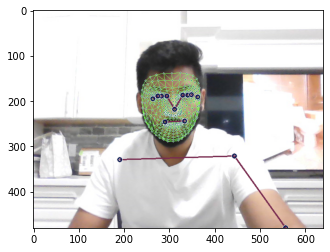

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract the keypoint values from the output

In [10]:
# Concatenate results values into a numpy array
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()if results.right_hand_landmarks else np.zeros(1404)
    return np.concatenate([pose,face,lh,rh])

In [11]:
extract_keypoints(results).shape

(1662,)

In [15]:
result_test = extract_keypoints(results)

In [16]:
result_test

array([ 0.48901987,  0.45451823, -1.03611445, ...,  0.        ,
        0.        ,  0.        ])

In [17]:
np.save('0', result_test)

In [18]:
np.load('0.npy')

array([ 0.48901987,  0.45451823, -1.03611445, ...,  0.        ,
        0.        ,  0.        ])

# Setting up the folder for creating the collection

In [28]:
# Creating the path to export the data of numpy array
DATA_PATH = os.path.join('MP_data')

# Specify the actions that need to be detected.
actions = np.array(['hello', 'thanks','Iloveyou'])

# Specify the number of videos of data to select.
no_sequences = 30

# Video are be 30 frames in length
sequence_length = 30

In [29]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collecting keypoint values for training and testing our data.

In [30]:
# writing a loop to take a snapshot in each point of time.

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through each action
    for action in actions:
        # Loops through the sequences in videos
        for sequence in range(no_sequences):
            #Loop through video length aka sequence length
            for frame_num in range(sequence_length):
        

                #Reads the feed from the webcam
                ret, frame = cap.read()

                # Inserting the detection code below.
                image, results = mediapipe_detection(frame, holistic)
                #print(results)


                # Draw the landmarks to our live feed
                #draw_landmarks(image, results)
                draw_styled_landmarks(image, results)

                # Apply the logic for collecting 

                # If frame is 0 then excute the following
                if frame_num == 0:

                    #The following code outputs text in our screen
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)

                    cv2.putText(image, 'Collecting frame for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frame for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)


                # This code collects the keypoints and saves it in the root folder.
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)


                #shows the feed to the screen, pass the frame or image from webcam.
                cv2.imshow('OpenCV Feed', image)

                # Stops the video once we escape from the loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [27]:
cap.release()
cv2.destroyAllWindows()